In [ ]:
# Instalação de dependências
!pip install --quiet plotly==5.24.1 seaborn statsmodels ydata-profiling scikit-learn


In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from ydata_profiling import ProfileReport

try:
    from google.colab import files
    from google.colab import drive
    COLAB = True
except Exception:
    COLAB = False


In [ ]:
# Carregar dataset
LOCAL_FILENAME = "Students_gamification_grades.csv"

if os.path.exists(LOCAL_FILENAME):
    print(f"Arquivo encontrado: {LOCAL_FILENAME}")
    df = pd.read_csv(LOCAL_FILENAME, encoding='utf-8', low_memory=False)
else:
    if COLAB:
        print("Faça upload do arquivo Students_gamification_grades.csv")
        uploaded = files.upload()
        first = next(iter(uploaded.keys()))
        LOCAL_FILENAME = first
        df = pd.read_csv(first, encoding='utf-8', low_memory=False)
    else:
        raise FileNotFoundError("Coloque o CSV no mesmo diretório ou faça upload no Colab.")

print("Dataset carregado com sucesso!")
print("Dimensões:", df.shape)
display(df.head())


Arquivo encontrado: Students_gamification_grades.csv
Dataset carregado com sucesso!
Dimensões: (69, 16)


,Student_ID,Practice_Exam,Final_Exam,User,Avg_Grade_Q1,Avg_Grade_Q2,Avg_Grade_Q3,Avg_Grade_Q4,Avg_Grade_Q5,Avg_Grade_Q6,No_access_Q1,No_access_Q2,No_access_Q3,No_access_Q4,No_access_Q5,No_access_Q6
0,1046,9.33,7.98,1,6.00,10.0,10.0,10.0,0.0,8.0,1,1,1,1,0,1
1,1048,2.89,6.49,0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,1050,7.67,6.90,1,9.00,10.0,10.0,10.0,10.0,10.0,1,1,1,1,1,1
3,1052,4.97,7.69,1,6.00,9.0,5.0,4.0,9.0,4.0,2,2,2,1,1,2
4,1054,3.89,7.78,1,9.33,10.0,10.0,10.0,10.0,10.0,12,1,1,1,1,1


In [ ]:
# Limpeza e relatório inicial
df.dropna(axis=1, how='all', inplace=True)
df.reset_index(drop=True, inplace=True)
print("Após limpeza, shape:", df.shape)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Colunas numéricas detectadas:", numeric_cols)

target_col = "Final_Exam" if "Final_Exam" in df.columns else numeric_cols[-1]
print("Coluna alvo:", target_col)

profile = ProfileReport(df, title="Relatório - Gamification Students Grades", minimal=True)
profile.to_file("relatorio_gamificacao.html")
print("Relatório salvo: relatorio_gamificacao.html")


Após limpeza, shape: (69, 16)
Colunas numéricas detectadas: ['Student_ID', 'Practice_Exam', 'Final_Exam', 'User', 'Avg_Grade_Q1', 'Avg_Grade_Q2', 'Avg_Grade_Q3', 'Avg_Grade_Q4', 'Avg_Grade_Q5', 'Avg_Grade_Q6', 'No_access_Q1', 'No_access_Q2', 'No_access_Q3', 'No_access_Q4', 'No_access_Q5', 'No_access_Q6']
Coluna alvo: Final_Exam


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:00<00:00, 107.08it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Relatório salvo: relatorio_gamificacao.html


In [ ]:
# Métricas de engajamento
avg_cols = [c for c in df.columns if c.lower().startswith('avg_grade_q')]
noaccess_cols = [c for c in df.columns if c.lower().startswith('no_access_q')]

df['avg_all_q'] = df[avg_cols].mean(axis=1, skipna=True)
df['total_no_access'] = df[noaccess_cols].sum(axis=1)
df['engagement_score'] = df['avg_all_q'] / (1 + df['total_no_access'])

display(df[['avg_all_q','total_no_access','engagement_score']].describe())


,avg_all_q,total_no_access,engagement_score
count,69.000000,69.000000,69.000000
mean,3.953889,5.811594,0.429861
std,3.415834,5.732455,0.387344
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,4.611667,6.000000,0.456852
75%,6.833333,9.000000,0.704545
max,9.888333,22.000000,1.404762


In [ ]:
# Teste usuário vs não usuário
if 'User' in df.columns:
    group_user = df[df['User'] == 1][target_col].dropna()
    group_non  = df[df['User'] == 0][target_col].dropna()

    print("Tamanho grupos -> User:", len(group_user), " | Non:", len(group_non))
    tstat, pval = ttest_ind(group_user, group_non, equal_var=False, nan_policy='omit')
    print(f"T-test: t={tstat:.4f}, p={pval:.4f}")

    fig = px.box(df, x=df['User'].astype(str).replace({'0':'0 - Não','1':'1 - Sim'}),
                 y=target_col, title=f'Distribuição de {target_col} por grupo User')
    fig.show()
else:
    print("Coluna 'User' não encontrada — pulando teste de grupos.")


Tamanho grupos -> User: 44  | Non: 25
T-test: t=3.1420, p=0.0029


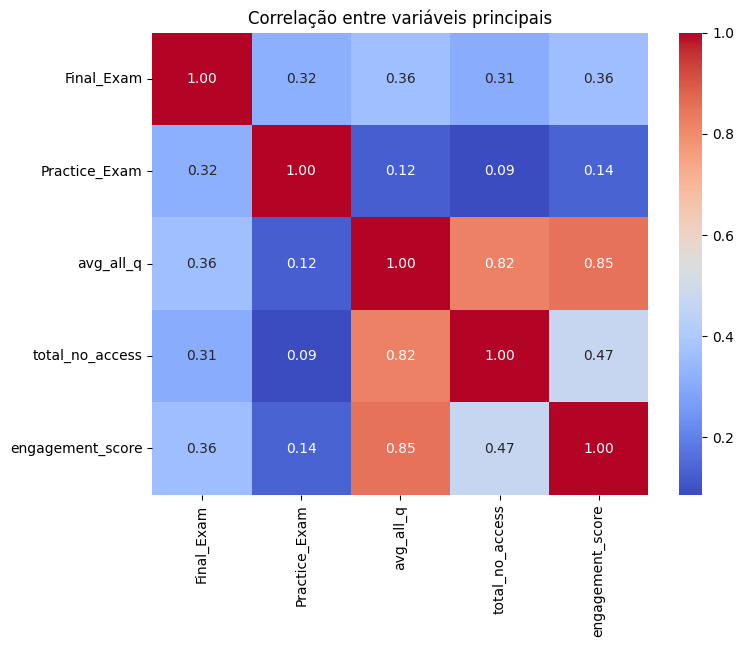

Pearson avg_all_q vs Final_Exam: r=0.364, p=0.0021
Pearson total_no_access vs Final_Exam: r=0.306, p=0.0106
Pearson engagement_score vs Final_Exam: r=0.361, p=0.0023


In [ ]:
# Engajamento e desempenho
corr_vars = [c for c in ['Final_Exam','Practice_Exam','avg_all_q','total_no_access','engagement_score'] if c in df.columns]
corr = df[corr_vars].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlação entre variáveis principais")
plt.show()

for c in ['avg_all_q','total_no_access','engagement_score']:
    if c in df.columns:
        sub = df[[c,target_col]].dropna()
        r,p = pearsonr(sub[c], sub[target_col])
        print(f"Pearson {c} vs {target_col}: r={r:.3f}, p={p:.4f}")


In [ ]:
# Regressões
if 'engagement_score' in df.columns:
    model_uni = smf.ols(f"{target_col} ~ engagement_score", data=df).fit()
    print(model_uni.summary())

features = [f for f in ['Practice_Exam','User','avg_all_q','total_no_access','engagement_score'] if f in df.columns]
if features:
    formula = f"{target_col} ~ " + " + ".join(features)
    model_multi = smf.ols(formula, data=df).fit()
    print("\nRegressão multivariada:")
    print(model_multi.summary())


                            OLS Regression Results                            
Dep. Variable:             Final_Exam   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     10.02
Date:                Thu, 09 Oct 2025   Prob (F-statistic):            0.00233
Time:                        22:40:04   Log-Likelihood:                -118.90
No. Observations:                  69   AIC:                             241.8
Df Residuals:                      67   BIC:                             246.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.3682      0.248  

In [ ]:
profile

Importância das features (RandomForest):


,0
Practice_Exam,0.463761
avg_all_q,0.294175
engagement_score,0.156145
total_no_access,0.077191
User,0.008729


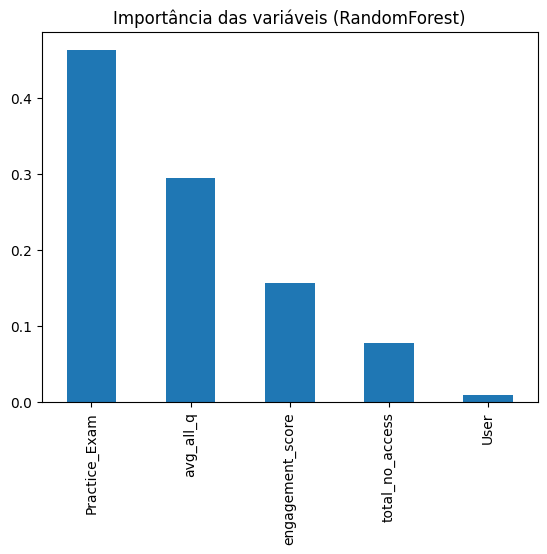

In [ ]:
# Importância das features
df_rf = df[[f for f in features if f in df.columns] + [target_col]].dropna()
if not df_rf.empty:
    X = df_rf.drop(columns=[target_col])
    y = df_rf[target_col]
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X, y)
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("Importância das features (RandomForest):")
    display(importances)
    importances.plot(kind='bar', title="Importância das variáveis (RandomForest)")
    plt.show()


In [ ]:
# Clusterização
cluster_features = [f for f in ['avg_all_q','total_no_access','engagement_score'] if f in df.columns]
if len(cluster_features) >= 2:
    scaler = StandardScaler()
    Xc = scaler.fit_transform(df[cluster_features].fillna(0))
    km = KMeans(n_clusters=2, random_state=42, n_init=10).fit(Xc)
    df['cluster'] = km.labels_

    fig = px.box(df, x='cluster', y=target_col, title=f'{target_col} por Cluster (KMeans)')
    fig.show()
    display(df.groupby('cluster')[cluster_features + [target_col]].mean())


,avg_all_q,total_no_access,engagement_score,Final_Exam
cluster,,,,
0,6.321357,9.302326,0.678149,7.297209
1,0.038462,0.038462,0.019231,6.386923


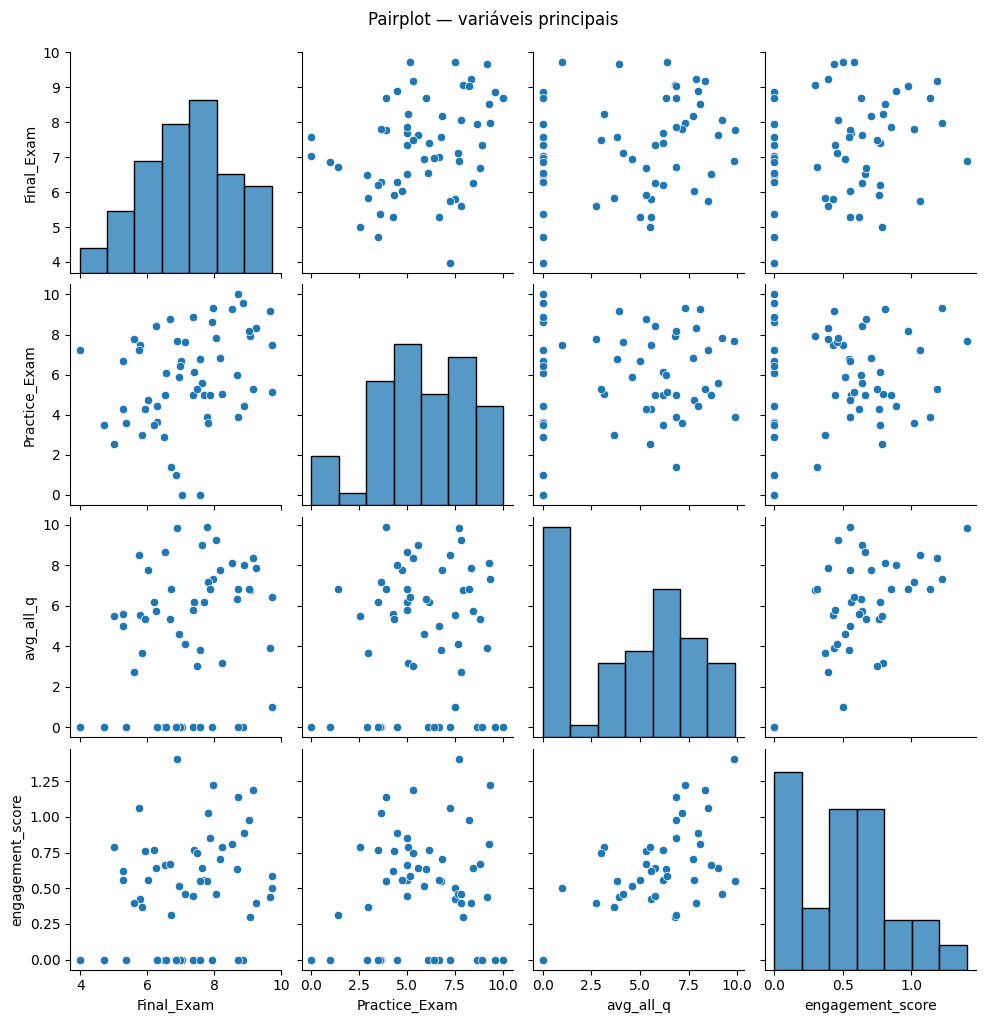

In [ ]:
# Visualizações adicionais
fig = px.scatter(df, x='engagement_score', y=target_col, trendline='ols',
                 title='Engagement Score vs Final Exam (linha de tendência)')
fig.show()

sns.pairplot(df[[c for c in ['Final_Exam','Practice_Exam','avg_all_q','engagement_score'] if c in df.columns]].dropna())
plt.suptitle("Pairplot — variáveis principais", y=1.02)
plt.show()


In [ ]:
# Salvar resultados
df[['User','avg_all_q','total_no_access','engagement_score','Final_Exam']].to_csv("gamificacao_resultados.csv", index=False)
print("Resultados salvos: gamificacao_resultados.csv")

if COLAB:
    try:
        drive.mount('/content/drive', force_remount=False)
        !cp gamificacao_resultados.csv /content/drive/MyDrive/
        print("Arquivo copiado para seu Google Drive (/MyDrive/)")
    except Exception as e:
        print("Falha ao salvar no Drive:", e)

print("\nAnálise concluída com sucesso!")

Resultados salvos: gamificacao_resultados.csv
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arquivo copiado para seu Google Drive (/MyDrive/)

Análise concluída com sucesso!
